In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam
import seaborn
from scipy.optimize import fsolve, root, least_squares
import sklearn.decomposition
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import sys

<IPython.core.display.Javascript object>

In [2]:
sys.path.insert(0, '..')

In [3]:
import scripts.generate_systematic_paths

In [4]:
version_str = "v4"
output_dir = f"../output/{version_str}/fair/"
date_str = "2022-02-14"
temps = pd.read_csv("{}fair_output_quantiles_{}_{}.csv".format(output_dir, date_str, version_str))
fair_df = pd.read_csv('{}fair_output_raw_{}_{}.csv'.format(output_dir, date_str, version_str), index_col=0)
fair_df

,scenario,1765,1766,1767,1768,1769,1770,1771,1772,1773,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.002751,0.005241,0.007940,0.012981,0.018950,0.025513,0.029475,0.030094,0.030464,...,0.312867,0.310305,0.307748,0.305196,0.302648,0.300105,0.297567,0.295033,0.292504,0.289980
1,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003864,0.007122,0.010898,0.020395,0.031454,0.043210,0.047838,0.043892,0.041129,...,0.325923,0.322226,0.318540,0.314863,0.311197,0.307541,0.303895,0.300260,0.296635,0.293022
2,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.015027,0.025776,0.035114,0.046443,0.057942,0.069351,0.076312,0.077298,0.078463,...,0.404382,0.401322,0.398268,0.395220,0.392179,0.389145,0.386117,0.383095,0.380081,0.377073
3,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003456,0.005529,0.007669,0.012386,0.017598,0.022956,0.024841,0.023868,0.022721,...,0.401651,0.398589,0.395533,0.392484,0.389440,0.386403,0.383372,0.380348,0.377330,0.374319
4,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.005983,0.010959,0.015759,0.022375,0.029606,0.037201,0.042308,0.042533,0.043916,...,0.276379,0.274497,0.272622,0.270754,0.268893,0.267039,0.265191,0.263351,0.261517,0.259691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,scen_2030fact1.32_nz2200_ov0_meth0.75,-0.002594,-0.003396,-0.002763,0.003357,0.011730,0.021526,0.026191,0.026982,0.025351,...,3.112862,3.112999,3.113137,3.113277,3.113418,3.113560,3.113704,3.113849,3.113995,3.114143
21596,scen_2030fact1.32_nz2200_ov0_meth0.75,0.002257,0.004585,0.007460,0.014016,0.022098,0.031179,0.036468,0.038749,0.039038,...,4.182481,4.183843,4.185191,4.186524,4.187842,4.189147,4.190437,4.191713,4.192976,4.194225
21597,scen_2030fact1.32_nz2200_ov0_meth0.75,0.005314,0.009809,0.014304,0.021737,0.030238,0.039397,0.044933,0.045437,0.045969,...,5.413546,5.415801,5.418031,5.420236,5.422417,5.424574,5.426707,5.428816,5.430902,5.432965
21598,scen_2030fact1.32_nz2200_ov0_meth0.75,0.001698,0.003474,0.005696,0.010695,0.016892,0.023899,0.028145,0.029651,0.030138,...,4.212919,4.216539,4.220138,4.223716,4.227274,4.230811,4.234328,4.237825,4.241301,4.244757


In [5]:
quantiles = [0.1,0.33,0.5,0.66,0.9]
norm_years = [str(x) for x in np.arange(2000, 2021, 1)]
fair_df_norm = fair_df.copy()
fair_df_norm.iloc[:, 1:] = (fair_df_norm.iloc[:, 1:].T + 0.85 - fair_df_norm.loc[:, norm_years].mean(axis=1)).T
norm_runs_quantiles = fair_df.groupby("scenario").quantile(quantiles)
norm_runs_quantiles = norm_runs_quantiles.reset_index()
norm_runs_quantiles

,scenario,level_1,1765,1766,1767,1768,1769,1770,1771,1772,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.10,-0.000821,-0.000697,0.000245,0.005559,0.013279,0.022561,0.026562,0.025395,...,0.269397,0.266415,0.263442,0.260477,0.257522,0.254575,0.251638,0.248705,0.245513,0.242331
1,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.33,0.003000,0.005411,0.007984,0.014730,0.022152,0.030238,0.035031,0.035954,...,0.320570,0.317339,0.314115,0.310899,0.307692,0.304492,0.301300,0.298117,0.294942,0.291775
2,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.50,0.003766,0.006994,0.010551,0.017957,0.025051,0.033267,0.038770,0.039291,...,0.401214,0.397991,0.394772,0.391558,0.387670,0.383583,0.379575,0.376145,0.372719,0.369299
3,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.66,0.005610,0.010190,0.014566,0.021852,0.030457,0.039768,0.045362,0.044170,...,0.459252,0.454534,0.449826,0.445130,0.440444,0.435769,0.431105,0.426453,0.421812,0.417182
4,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.90,0.013602,0.023293,0.031828,0.042917,0.054024,0.065091,0.070097,0.067155,...,0.533576,0.530141,0.526713,0.523291,0.519876,0.516469,0.513068,0.509674,0.506288,0.502909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,scen_2030fact1.32_nz2200_ov0_meth0.75,0.10,-0.000821,-0.000697,0.000245,0.005559,0.013279,0.022561,0.026562,0.025395,...,2.962986,2.964785,2.966578,2.968365,2.970145,2.971918,2.973686,2.975447,2.977201,2.978949
4496,scen_2030fact1.32_nz2200_ov0_meth0.75,0.33,0.003000,0.005411,0.007984,0.014730,0.022152,0.030238,0.035031,0.035954,...,3.697160,3.699724,3.702277,3.704819,3.707352,3.709874,3.712386,3.714888,3.717380,3.719862
4497,scen_2030fact1.32_nz2200_ov0_meth0.75,0.50,0.003766,0.006994,0.010551,0.017957,0.025051,0.033267,0.038770,0.039291,...,3.888266,3.889871,3.891469,3.893059,3.894642,3.896217,3.897785,3.899345,3.900898,3.902444
4498,scen_2030fact1.32_nz2200_ov0_meth0.75,0.66,0.005610,0.010190,0.014566,0.021852,0.030457,0.039768,0.045362,0.044170,...,4.113569,4.114756,4.115930,4.117091,4.118240,4.119377,4.120500,4.121612,4.122712,4.123799


In [6]:
norm_runs_quantiles = norm_runs_quantiles.rename(columns={"level_1": "quantile"})

In [7]:
norm_2020 = False
minyear = 2040
years = np.arange(minyear, 2301, 10)
if norm_2020:
    fair_df = fair_df_norm
    temps = pd.merge(temps.iloc[:, :7], norm_runs_quantiles, on=["scenario", "quantile"])
    temps = temps.loc[:, temps.columns[:7].append(pd.Index([str(x) for x in range(minyear, 2301)]))]

In [8]:
temps_py = pyam.IamDataFrame(temps)
temps_py.data

,model,scenario,region,variable,unit,year,climate_model,quantile,value
0,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.10,0.932584
1,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.33,0.949845
2,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.50,0.960186
3,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.66,0.971336
4,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.90,0.996931
...,...,...,...,...,...,...,...,...,...
1309495,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.10,2.890492
1309496,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.33,3.609135
1309497,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.50,3.904282
1309498,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.66,4.085395


pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: NameVanished - region: World - variable: Surface Temperature - climate_model: FaIRv1.6.4 - quantile: 0.66'}, xlabel='Year', ylabel='K'>

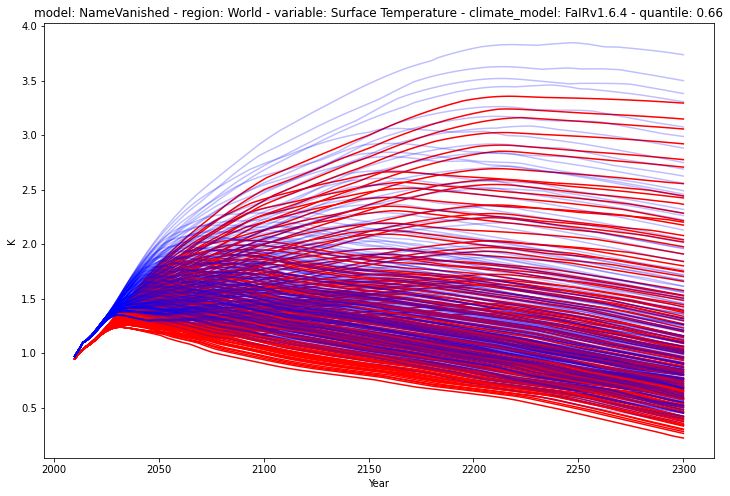

In [9]:
plt.figure(figsize=(12, 8))
ax=plt.subplot()
temps_py.filter(quantile=0.33, scenario="*10000*").plot(ax=ax, color="r")
temps_py.filter(quantile=0.66, scenario="*10000*").plot(ax=ax, color="b", alpha=0.25)

In [10]:
temps

,climate_model,model,region,scenario,unit,variable,quantile,2010,2011,2012,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.25,K,Surface Temperature,0.1,0.932584,0.949229,0.965410,...,0.169997,0.166608,0.163233,0.159871,0.156523,0.153188,0.149867,0.146559,0.143265,0.140951
1,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.5,K,Surface Temperature,0.1,0.932539,0.949206,0.965461,...,0.217677,0.214607,0.211549,0.208503,0.205470,0.202449,0.199440,0.196444,0.193460,0.190489
2,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-10000_meth0.75,K,Surface Temperature,0.1,0.932460,0.949167,0.965550,...,0.240569,0.237498,0.234438,0.231391,0.228356,0.225333,0.222322,0.219324,0.216338,0.213364
3,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-2500_meth0.25,K,Surface Temperature,0.1,0.932584,0.949229,0.965410,...,0.789249,0.788406,0.787563,0.786721,0.785879,0.785038,0.784198,0.783358,0.782519,0.781681
4,FaIRv1.6.4,NameVanished,World,scen_2030fact0.12_nz2040_ov-2500_meth0.5,K,Surface Temperature,0.1,0.932539,0.949206,0.965461,...,0.838614,0.837793,0.836974,0.836154,0.835335,0.834517,0.833699,0.832882,0.832065,0.831248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,FaIRv1.6.4,NameVanished,World,scen_2030fact1.32_nz2200_ov-7500_meth0.5,K,Surface Temperature,0.9,0.996854,1.026663,1.060538,...,4.151669,4.152037,4.152377,4.152690,4.152975,4.153232,4.153462,4.153664,4.153839,4.153987
4496,FaIRv1.6.4,NameVanished,World,scen_2030fact1.32_nz2200_ov-7500_meth0.75,K,Surface Temperature,0.9,0.996720,1.026592,1.060700,...,4.341270,4.341908,4.342517,4.343098,4.343650,4.344173,4.344668,4.345134,4.345573,4.345983
4497,FaIRv1.6.4,NameVanished,World,scen_2030fact1.32_nz2200_ov0_meth0.25,K,Surface Temperature,0.9,0.996931,1.026704,1.060446,...,4.260658,4.264124,4.267571,4.271000,4.274411,4.277804,4.281178,4.284534,4.287872,4.291192
4498,FaIRv1.6.4,NameVanished,World,scen_2030fact1.32_nz2200_ov0_meth0.5,K,Surface Temperature,0.9,0.996854,1.026663,1.060538,...,4.381818,4.385430,4.389023,4.392596,4.396151,4.399688,4.403205,4.406704,4.410184,4.413646


In [11]:
temp_years = temps_py.filter(year=years)

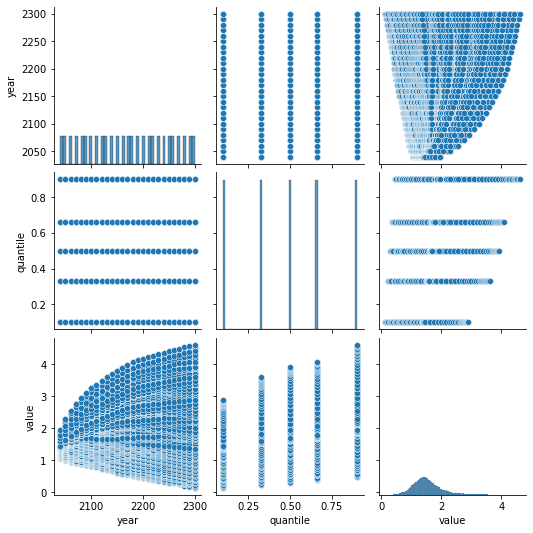

In [12]:
seaborn.pairplot(temp_years.data)

In [13]:
temps_90 = pyam.IamDataFrame(temps).filter(quantile=0.9).timeseries()
temps_50 = pyam.IamDataFrame(temps).filter(quantile=0.5).timeseries()
temps_10 = pyam.IamDataFrame(temps).filter(quantile=0.1).timeseries()
temps_33 = pyam.IamDataFrame(temps).filter(quantile=0.33).timeseries()
temps_66 = pyam.IamDataFrame(temps).filter(quantile=0.66).timeseries()
temps_90 = temps_90.reset_index(drop=True)
temps_50 = temps_50.reset_index(drop=True)
temps_10 = temps_10.reset_index(drop=True)
temps_33 = temps_33.reset_index(drop=True)
temps_66 = temps_66.reset_index(drop=True)
quantile_range = [0.10, 0.33, 0.50, 0.66, 0.90, "all"]
decomposers2 = {}
decomposers3 = {}
decomposers4 = {}
decomposers5 = {}
temp_data = {
    0.10: temps_10, 0.33: temps_33, 0.50: temps_50, 0.90:temps_90, 
    0.66: temps_66, "all": temps_py.timeseries().reset_index(drop=True)
}
for i in quantile_range:
    decomposers2[i] = sklearn.decomposition.PCA(2).fit(temp_data[i])
    decomposers3[i] = sklearn.decomposition.PCA(3).fit(temp_data[i])
    decomposers4[i] = sklearn.decomposition.PCA(4).fit(temp_data[i])
    decomposers5[i] = sklearn.decomposition.PCA(5).fit(temp_data[i])

# Try random forest method

In [14]:
pcacols = ["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]
# Switch between on and off to study the impact of considering all quantiles
if (False):
    pcadf = pd.DataFrame(
        decomposers5[0.5].transform(temps_py.filter(quantile=0.5).timeseries()), 
        columns=pcacols,
        index=temps_py.filter(quantile=0.5).timeseries().index
    ).reset_index()
else:
    pcadf = pd.DataFrame(
        decomposers5["all"].transform(temps_py.timeseries()), 
        columns=pcacols,
        index=temps_py.timeseries().index
    ).reset_index()

In [15]:
def decode_scen(df):
    df["factor2030"] = [float(x[1][:4]) for x in df["scenario"].str.split("2030fact")]
    df["nzdate"] = [int(x[1][:4]) for x in df["scenario"].str.split("_nz")]
    df["overshoot"] = [float(x[3][2:]) for x in df["scenario"].str.split("_")]
    df["methane"] = [float(x[4][4:]) for x in df["scenario"].str.split("_")]
    # The numerical stability of calculations is higher when variables are all of order 1
    df["nzreduced"] = df["nzdate"] / 100 - 20
    df["overshootreduced"] = df["overshoot"]/10000
    return df
pcadf = decode_scen(pcadf)
pcadf

,model,scenario,region,variable,unit,climate_model,quantile,PCA1,PCA2,PCA3,PCA4,PCA5,factor2030,nzdate,overshoot,methane,nzreduced,overshootreduced
0,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.10,-16.606031,-0.606375,-0.550879,-0.198509,-0.059129,0.12,2040,-10000.0,0.25,0.4,-1.0
1,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.33,-14.395001,0.050277,-0.394888,0.231765,0.252606,0.12,2040,-10000.0,0.25,0.4,-1.0
2,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.50,-13.262292,0.707713,-0.488155,0.202245,-0.076384,0.12,2040,-10000.0,0.25,0.4,-1.0
3,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.66,-12.460885,0.962608,-0.359962,0.328655,-0.135353,0.12,2040,-10000.0,0.25,0.4,-1.0
4,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.90,-10.843689,1.450493,0.081718,0.531582,-0.279401,0.12,2040,-10000.0,0.25,0.4,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.10,15.816842,-2.100417,-0.617982,-0.454528,0.085754,1.32,2200,0.0,0.75,2.0,0.0
4496,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.33,24.519780,-2.150661,-0.453872,-0.401109,-0.070481,1.32,2200,0.0,0.75,2.0,0.0
4497,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.50,28.968867,-2.310612,-0.510951,0.112578,0.333311,1.32,2200,0.0,0.75,2.0,0.0
4498,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.66,31.447401,-1.329638,-0.396346,-0.179470,-0.123920,1.32,2200,0.0,0.75,2.0,0.0


In [16]:
functional_cols = ["factor2030", "nzreduced", "overshootreduced", "methane"]
pcadf = pcadf.set_index("scenario", drop=True).loc[:, ["quantile"] + functional_cols + pcacols]
pcadf

,quantile,factor2030,nzreduced,overshootreduced,methane,PCA1,PCA2,PCA3,PCA4,PCA5
scenario,,,,,,,,,,
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.10,0.12,0.4,-1.0,0.25,-16.606031,-0.606375,-0.550879,-0.198509,-0.059129
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.33,0.12,0.4,-1.0,0.25,-14.395001,0.050277,-0.394888,0.231765,0.252606
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.50,0.12,0.4,-1.0,0.25,-13.262292,0.707713,-0.488155,0.202245,-0.076384
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.66,0.12,0.4,-1.0,0.25,-12.460885,0.962608,-0.359962,0.328655,-0.135353
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.90,0.12,0.4,-1.0,0.25,-10.843689,1.450493,0.081718,0.531582,-0.279401
...,...,...,...,...,...,...,...,...,...,...
scen_2030fact1.32_nz2200_ov0_meth0.75,0.10,1.32,2.0,0.0,0.75,15.816842,-2.100417,-0.617982,-0.454528,0.085754
scen_2030fact1.32_nz2200_ov0_meth0.75,0.33,1.32,2.0,0.0,0.75,24.519780,-2.150661,-0.453872,-0.401109,-0.070481
scen_2030fact1.32_nz2200_ov0_meth0.75,0.50,1.32,2.0,0.0,0.75,28.968867,-2.310612,-0.510951,0.112578,0.333311


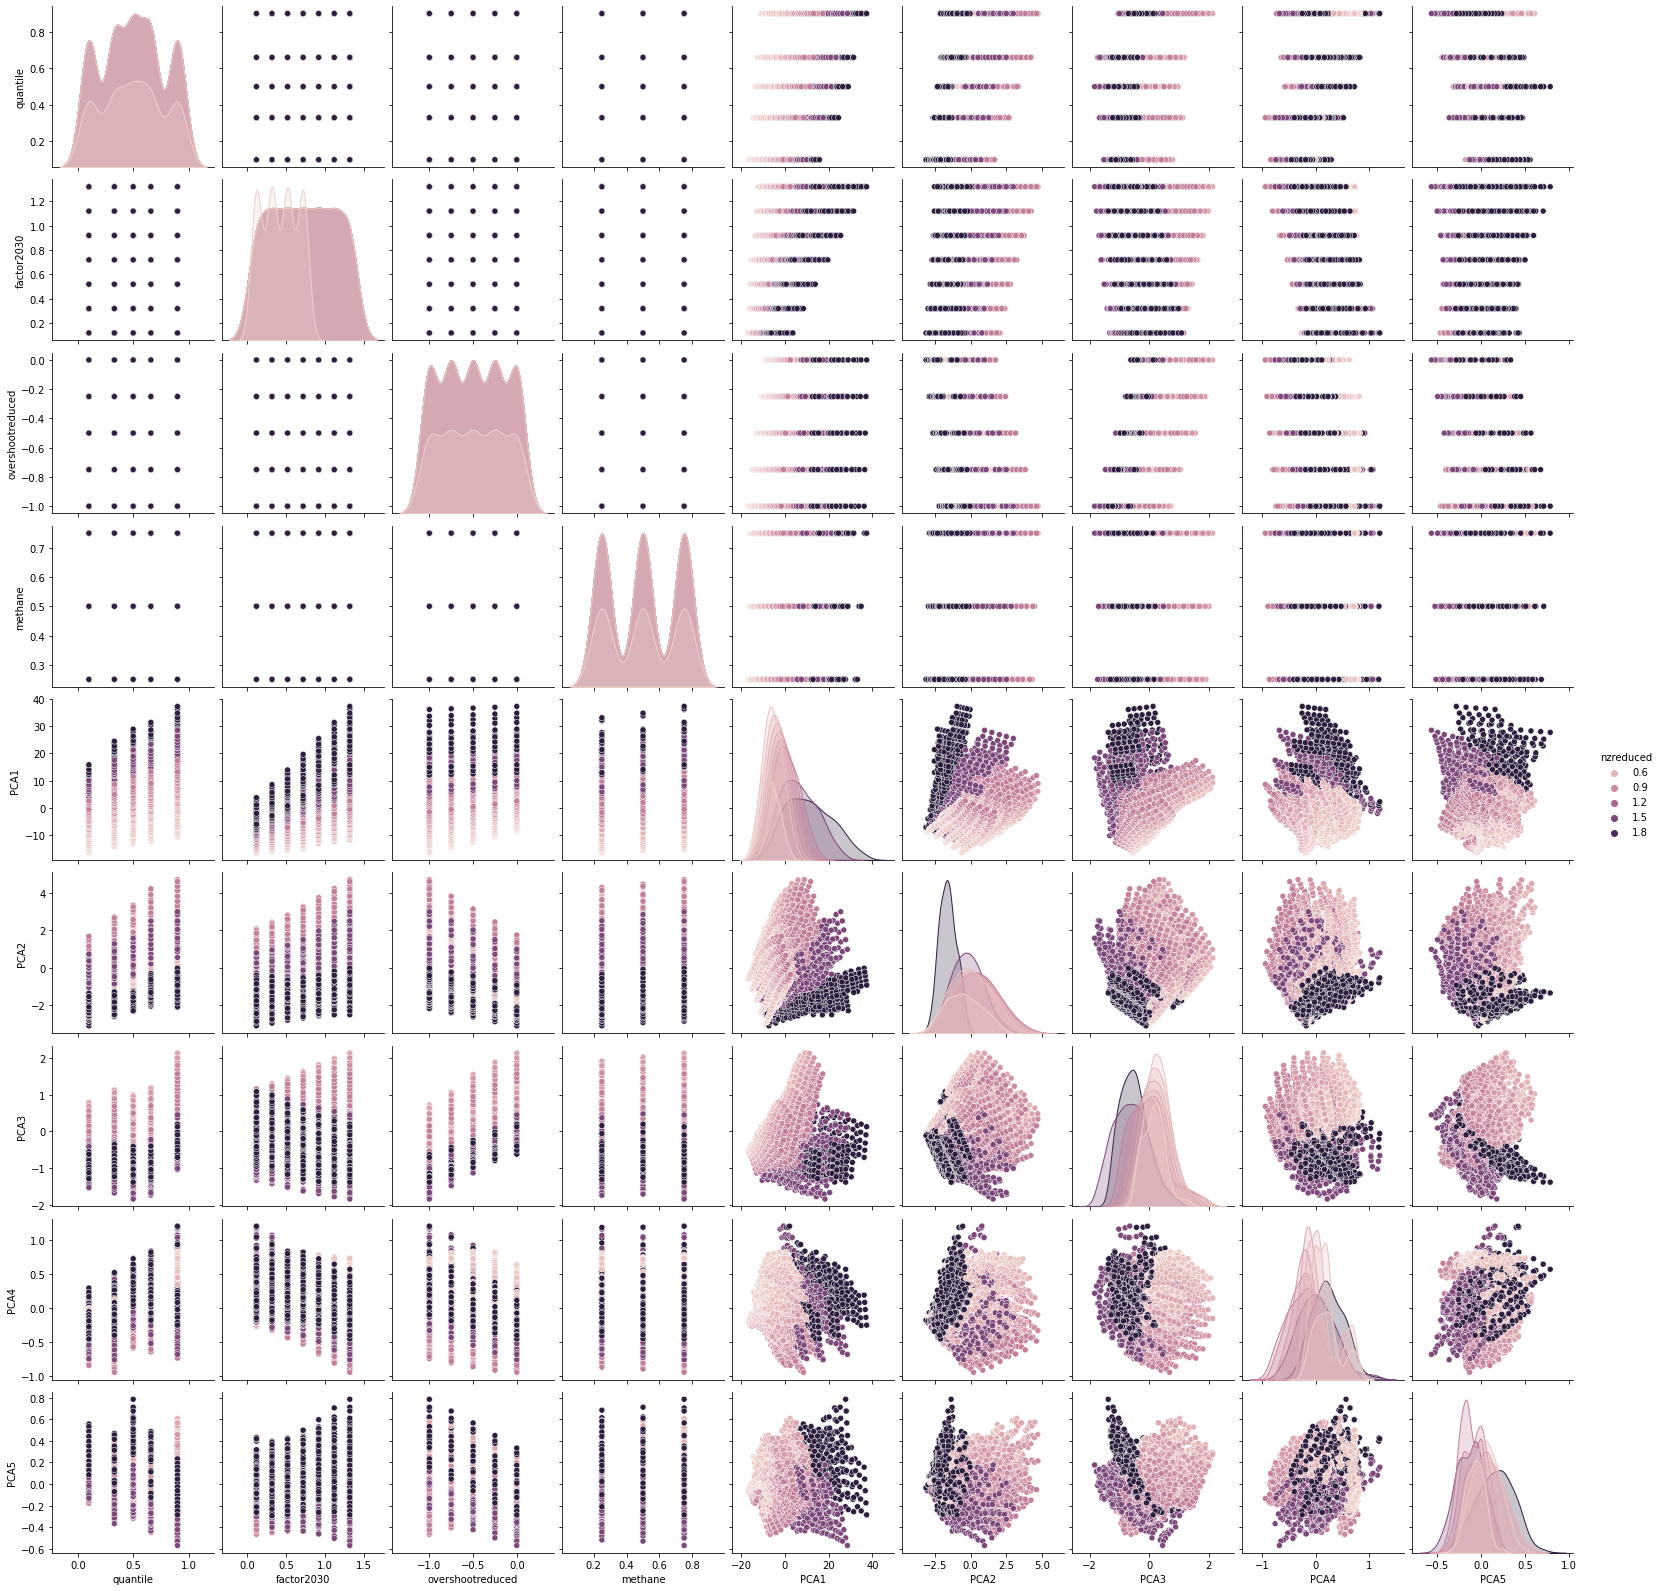

In [17]:
seaborn.pairplot(pcadf.reset_index(drop=True), hue="nzreduced")

In [18]:
pca_train, pca_test, pca_res_train, pca_res_test = train_test_split(
    pcadf.loc[:, pcacols + ["quantile"]], pcadf.loc[:, functional_cols], test_size = 0.2, random_state = 4
)

In [19]:
pcadf

,quantile,factor2030,nzreduced,overshootreduced,methane,PCA1,PCA2,PCA3,PCA4,PCA5
scenario,,,,,,,,,,
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.10,0.12,0.4,-1.0,0.25,-16.606031,-0.606375,-0.550879,-0.198509,-0.059129
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.33,0.12,0.4,-1.0,0.25,-14.395001,0.050277,-0.394888,0.231765,0.252606
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.50,0.12,0.4,-1.0,0.25,-13.262292,0.707713,-0.488155,0.202245,-0.076384
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.66,0.12,0.4,-1.0,0.25,-12.460885,0.962608,-0.359962,0.328655,-0.135353
scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.90,0.12,0.4,-1.0,0.25,-10.843689,1.450493,0.081718,0.531582,-0.279401
...,...,...,...,...,...,...,...,...,...,...
scen_2030fact1.32_nz2200_ov0_meth0.75,0.10,1.32,2.0,0.0,0.75,15.816842,-2.100417,-0.617982,-0.454528,0.085754
scen_2030fact1.32_nz2200_ov0_meth0.75,0.33,1.32,2.0,0.0,0.75,24.519780,-2.150661,-0.453872,-0.401109,-0.070481
scen_2030fact1.32_nz2200_ov0_meth0.75,0.50,1.32,2.0,0.0,0.75,28.968867,-2.310612,-0.510951,0.112578,0.333311


In [20]:
randforest = DecisionTreeRegressor()
randforest = randforest.fit(pca_train.values, pca_res_train.values)
randforest.score(pca_test.values, pca_res_test.values)

0.468986647830253

In [21]:
pca_train

,PCA1,PCA2,PCA3,PCA4,PCA5,quantile
scenario,,,,,,
scen_2030fact0.12_nz2040_ov0_meth0.5,-2.107356,-1.623861,0.518272,0.207303,-0.208521,0.66
scen_2030fact1.32_nz2100_ov-5000_meth0.5,7.963516,1.687641,-0.123958,-0.490519,-0.128070,0.50
scen_2030fact0.52_nz2050_ov-10000_meth0.5,-9.808860,1.416086,-0.380326,0.165459,0.046273,0.50
scen_2030fact1.32_nz2060_ov-10000_meth0.5,-2.950792,3.246133,0.256956,0.008769,0.165390,0.66
scen_2030fact0.32_nz2200_ov-5000_meth0.5,-4.093134,-2.415950,-0.510034,-0.021124,0.182482,0.10
...,...,...,...,...,...,...
scen_2030fact1.12_nz2090_ov0_meth0.75,5.061934,-0.320188,0.838836,-0.721938,0.006125,0.33
scen_2030fact0.32_nz2040_ov-5000_meth0.25,-5.426541,0.268421,0.315306,0.676555,-0.283645,0.90
scen_2030fact0.72_nz2100_ov-10000_meth0.75,-0.527868,1.983508,-0.950998,-0.103829,-0.246867,0.50


In [22]:
pca_res_train

,factor2030,nzreduced,overshootreduced,methane
scenario,,,,
scen_2030fact0.12_nz2040_ov0_meth0.5,0.12,0.4,0.00,0.50
scen_2030fact1.32_nz2100_ov-5000_meth0.5,1.32,1.0,-0.50,0.50
scen_2030fact0.52_nz2050_ov-10000_meth0.5,0.52,0.5,-1.00,0.50
scen_2030fact1.32_nz2060_ov-10000_meth0.5,1.32,0.6,-1.00,0.50
scen_2030fact0.32_nz2200_ov-5000_meth0.5,0.32,2.0,-0.50,0.50
...,...,...,...,...
scen_2030fact1.12_nz2090_ov0_meth0.75,1.12,0.9,0.00,0.75
scen_2030fact0.32_nz2040_ov-5000_meth0.25,0.32,0.4,-0.50,0.25
scen_2030fact0.72_nz2100_ov-10000_meth0.75,0.72,1.0,-1.00,0.75


[array([[1.        , 0.93060307],
        [0.93060307, 1.        ]]),
 array([[1.        , 0.96506449],
        [0.96506449, 1.        ]]),
 array([[1.        , 0.95993362],
        [0.95993362, 1.        ]]),
 array([[1.        , 0.05975097],
        [0.05975097, 1.        ]])]

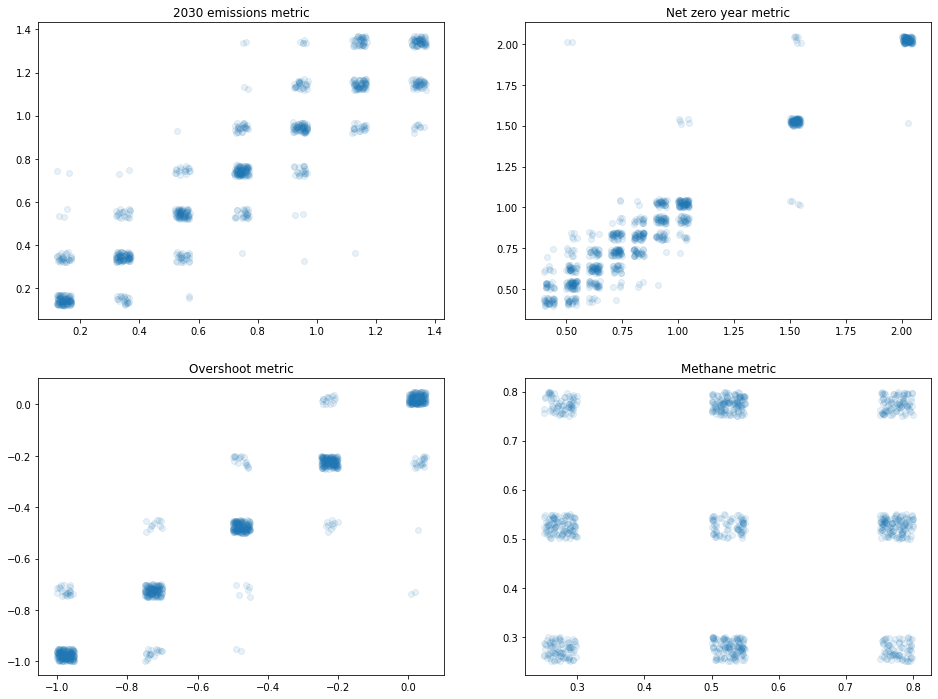

In [23]:
predictions = randforest.predict(pca_test.values)
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
corcoefs = []
plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(predictions[:, i]+0.05*np.random.rand(len(predictions)), pca_res_test.iloc[:, i]+0.05*np.random.rand(len(predictions)), alpha=0.1)
    plt.title(titles[i])
    corcoefs.append(np.corrcoef(predictions[:, i], pca_res_test.iloc[:, i]))
corcoefs

# Try a polynomial relationship

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [25]:
# For smaller datasets, 5 polynomial degrees outperforms 6, but not for this dataset
poly = PolynomialFeatures(degree=6)
poly_train = poly.fit_transform(pca_train)
poly_test = poly.fit_transform(pca_test)

In [26]:
pca_train

,PCA1,PCA2,PCA3,PCA4,PCA5,quantile
scenario,,,,,,
scen_2030fact0.12_nz2040_ov0_meth0.5,-2.107356,-1.623861,0.518272,0.207303,-0.208521,0.66
scen_2030fact1.32_nz2100_ov-5000_meth0.5,7.963516,1.687641,-0.123958,-0.490519,-0.128070,0.50
scen_2030fact0.52_nz2050_ov-10000_meth0.5,-9.808860,1.416086,-0.380326,0.165459,0.046273,0.50
scen_2030fact1.32_nz2060_ov-10000_meth0.5,-2.950792,3.246133,0.256956,0.008769,0.165390,0.66
scen_2030fact0.32_nz2200_ov-5000_meth0.5,-4.093134,-2.415950,-0.510034,-0.021124,0.182482,0.10
...,...,...,...,...,...,...
scen_2030fact1.12_nz2090_ov0_meth0.75,5.061934,-0.320188,0.838836,-0.721938,0.006125,0.33
scen_2030fact0.32_nz2040_ov-5000_meth0.25,-5.426541,0.268421,0.315306,0.676555,-0.283645,0.90
scen_2030fact0.72_nz2100_ov-10000_meth0.75,-0.527868,1.983508,-0.950998,-0.103829,-0.246867,0.50


In [27]:
regression = linear_model.LinearRegression()
poly_model = regression.fit(poly_train, pca_res_train)
score = poly_model.score(poly_test, pca_res_test)
score

0.9698738627218042

In [28]:
poly_test

array([[ 1.00000000e+00, -6.31295590e+00, -1.63092564e+00, ...,
         9.89437831e-07,  9.94704896e-07,  1.00000000e-06],
       [ 1.00000000e+00,  2.76224544e+00,  1.23132344e-02, ...,
         3.48723858e-04, -2.33426868e-03,  1.56250000e-02],
       [ 1.00000000e+00, -8.07445066e+00,  1.89601069e+00, ...,
         1.86555907e-03,  5.39901477e-03,  1.56250000e-02],
       ...,
       [ 1.00000000e+00, -1.05591810e+01,  4.85823637e-02, ...,
         4.72092177e-08,  2.17276823e-07,  1.00000000e-06],
       [ 1.00000000e+00,  7.89734132e+00,  2.26229835e+00, ...,
         6.50047272e-03, -2.31795114e-02,  8.26539500e-02],
       [ 1.00000000e+00, -2.04974855e+00, -1.43607190e+00, ...,
         4.25835646e-08,  2.06357856e-07,  1.00000000e-06]])

In [29]:
pca_res_test

,factor2030,nzreduced,overshootreduced,methane
scenario,,,,
scen_2030fact0.52_nz2080_ov-2500_meth0.75,0.52,0.8,-0.25,0.75
scen_2030fact0.52_nz2150_ov-7500_meth0.5,0.52,1.5,-0.75,0.50
scen_2030fact0.92_nz2050_ov-10000_meth0.5,0.92,0.5,-1.00,0.50
scen_2030fact0.52_nz2090_ov-7500_meth0.25,0.52,0.9,-0.75,0.25
scen_2030fact0.32_nz2070_ov-2500_meth0.5,0.32,0.7,-0.25,0.50
...,...,...,...,...
scen_2030fact0.92_nz2200_ov-7500_meth0.75,0.92,2.0,-0.75,0.75
scen_2030fact0.32_nz2060_ov-5000_meth0.25,0.32,0.6,-0.50,0.25
scen_2030fact0.52_nz2090_ov-10000_meth0.25,0.52,0.9,-1.00,0.25


In [30]:
predicted = poly_model.predict(poly_test)
predicted_labelled = pd.DataFrame(predicted, columns=pca_res_test.columns, index=pca_res_test.index)
predicted_labelled

,factor2030,nzreduced,overshootreduced,methane
scenario,,,,
scen_2030fact0.52_nz2080_ov-2500_meth0.75,0.518818,0.798133,-0.244331,0.709373
scen_2030fact0.52_nz2150_ov-7500_meth0.5,0.507792,1.530835,-0.748640,0.521293
scen_2030fact0.92_nz2050_ov-10000_meth0.5,0.923007,0.513402,-0.994363,0.493510
scen_2030fact0.52_nz2090_ov-7500_meth0.25,0.503440,0.933472,-0.755156,0.250018
scen_2030fact0.32_nz2070_ov-2500_meth0.5,0.342328,0.679383,-0.249254,0.478475
...,...,...,...,...
scen_2030fact0.92_nz2200_ov-7500_meth0.75,0.893361,1.982835,-0.740924,0.785374
scen_2030fact0.32_nz2060_ov-5000_meth0.25,0.328950,0.635668,-0.490230,0.272678
scen_2030fact0.52_nz2090_ov-10000_meth0.25,0.543618,0.883384,-0.989592,0.212499


[array([[1.        , 0.99357231],
        [0.99357231, 1.        ]]),
 array([[1.        , 0.99080559],
        [0.99080559, 1.        ]]),
 array([[1.        , 0.99934746],
        [0.99934746, 1.        ]]),
 array([[1.       , 0.9560123],
        [0.9560123, 1.       ]])]

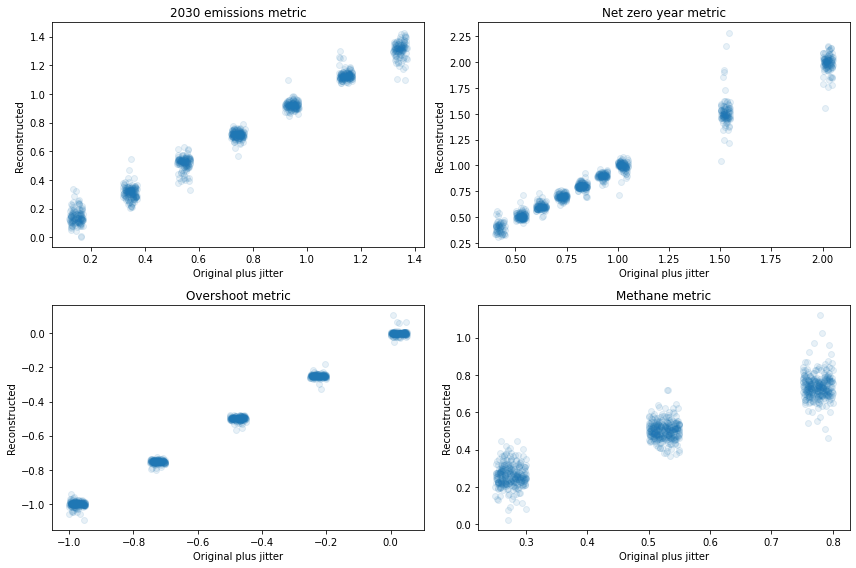

In [31]:
plt.figure(figsize=(12, 8))
corcoefs = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(pca_res_test.iloc[:, i]+0.05*np.random.rand(len(predicted)), predicted[:, i], alpha=0.1)
    plt.title(titles[i])
    plt.xlabel("Original plus jitter")
    plt.ylabel("Reconstructed")
    corcoefs.append(np.corrcoef(pca_res_test.iloc[:, i], predicted[:, i]))
plt.tight_layout()
corcoefs

In [32]:
# Interestingly, if the training data does not include different quantiles, 
# its ability to predict methane substantially declines (within the same quantile), 
# indicating an overtraining risk
q50 = pcadf[pcadf["quantile"] == 0.5].index
q50_test_ind = [i in q50 for i in pca_res_test.index]

[array([[1.        , 0.99357231],
        [0.99357231, 1.        ]]),
 array([[1.        , 0.99080559],
        [0.99080559, 1.        ]]),
 array([[1.        , 0.99934746],
        [0.99934746, 1.        ]]),
 array([[1.       , 0.9560123],
        [0.9560123, 1.       ]])]

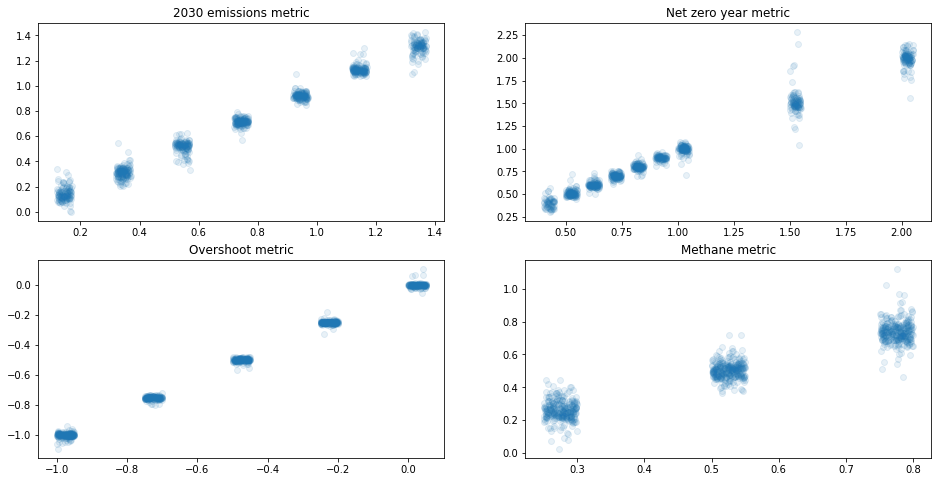

In [33]:
plt.figure(figsize=(16, 8))
corcoefsq5 = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(pca_res_test.iloc[q50_test_ind, i]+0.05*np.random.rand(sum(q50_test_ind)), predicted[q50_test_ind, i], alpha=0.1)
    plt.title(titles[i])
    corcoefsq5.append(np.corrcoef(pca_res_test.iloc[q50_test_ind, i], predicted[q50_test_ind, i]))
corcoefsq5

# Draw diagram of the process going from temperatures to emissions space

In [34]:
sr15_em = pyam.IamDataFrame("../input/complete_sr15_emissions.csv").filter(region="World", variable="*CO2")
scenario = "SSP2-45"
model = "MESSAGE-GLOBIOM 1.0"
basis_scen = sr15_em.filter(model=model, scenario=scenario, year=[2010, 2015, 2020])

pyam.core - INFO: Reading file ..\input\complete_sr15_emissions.csv


In [35]:
# We don't really want a positive overshoot
sum(predicted[:, 2] > 0) / len(predicted)

0.09555555555555556

In [36]:
sum(predicted[:, 2] > 0.01) / len(predicted)

0.0077777777777777776

In [37]:
nominated_scens = pca_test.iloc[:6, :]
scen = nominated_scens.copy()
quant_to_val = poly_model.predict(poly.fit_transform(scen))

In [38]:
try:
    del all_scens
except NameError:
    pass
yeargap = 10
max_grad = 5000
ind_name = 0
for scen_implied in quant_to_val:
    # Have to convert back from the reduced forms to the originals
    scen = basis_scen.filter(variable="*CO2").timeseries()
    scen[2030] = scen[2020] * scen_implied[0]
    net_zero = scen_implied[1] * 100 + 2000
    overshoot = min(scen_implied[2] * 10000, 0)
    for year in range(2030 + yeargap, int(min(net_zero, 2301)), yeargap):
        scen[year] = scen[2030] * (net_zero - year) / (net_zero - 2030)
    for year in range(int(np.ceil(net_zero/10)) * 10, 2301, yeargap):
        scen[year] = max([overshoot, scen[year - yeargap].values - max_grad])
    scen = scen.reset_index()
    scen = scen.reset_index()
    scen["scenario"] = nominated_scens.index[ind_name]
    ind_name += 1
    try:
        all_scens = all_scens.append(scen)
    except NameError:
        all_scens = scen
del all_scens["index"]
all_scens.head(5)

,model,scenario,region,variable,unit,2010,2020,2030,2040,2050,...,2210,2220,2230,2240,2250,2260,2270,2280,2290,2300
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2080_ov-2500_meth0.75,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21938.167300,17534.087907,13130.008514,...,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987,-2443.310987
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2150_ov-7500_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21471.930412,19727.429222,17982.928031,...,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158,-7486.404158
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.92_nz2050_ov-10000_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,39029.305544,20740.240746,2451.175949,...,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512,-9943.630512
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2090_ov-7500_meth0.25,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21287.916134,17927.402322,14566.888509,...,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227,-7551.555227
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.32_nz2070_ov-2500_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,14475.304135,10659.815197,6844.326259,...,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336,-2492.542336


In [39]:
decode_scen(pd.DataFrame({"scenario": nominated_scens.index}))

,scenario,factor2030,nzdate,overshoot,methane,nzreduced,overshootreduced
0,scen_2030fact0.52_nz2080_ov-2500_meth0.75,0.52,2080,-2500.0,0.75,0.8,-0.25
1,scen_2030fact0.52_nz2150_ov-7500_meth0.5,0.52,2150,-7500.0,0.50,1.5,-0.75
2,scen_2030fact0.92_nz2050_ov-10000_meth0.5,0.92,2050,-10000.0,0.50,0.5,-1.00
3,scen_2030fact0.52_nz2090_ov-7500_meth0.25,0.52,2090,-7500.0,0.25,0.9,-0.75
4,scen_2030fact0.32_nz2070_ov-2500_meth0.5,0.32,2070,-2500.0,0.50,0.7,-0.25
5,scen_2030fact0.92_nz2100_ov-5000_meth0.25,0.92,2100,-5000.0,0.25,1.0,-0.50


In [40]:
try:
    del all_scens_orig
except NameError:
    pass
yeargap = 10
max_grad = 5000
ind_name = 0
for ind, scen_implied in decode_scen(pd.DataFrame({"scenario": nominated_scens.index})).iterrows():
    # Have to convert back from the reduced forms to the originals
    scen = basis_scen.filter(variable="*CO2").timeseries()
    scen[2030] = scen[2020] * scen_implied["factor2030"]
    net_zero = scen_implied["nzdate"]
    overshoot = scen_implied["overshoot"]
    for year in range(2030 + yeargap, min(net_zero + 1, 2301), yeargap):
        scen[year] = scen[2030] * (net_zero - year) / (net_zero - 2030)
    for year in range(net_zero + yeargap, 2301, yeargap):
        scen[year] = max([overshoot, scen[year - yeargap].values - max_grad])
    scen = scen.reset_index()
    scen = scen.reset_index()
    scen["scenario"] = scen_implied["scenario"]
    try:
        all_scens_orig = all_scens_orig.append(scen)
    except NameError:
        all_scens_orig = scen
del all_scens_orig["index"]
all_scens_orig.head(5)

,model,scenario,region,variable,unit,2010,2020,2030,2040,2050,...,2210,2220,2230,2240,2250,2260,2270,2280,2290,2300
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2080_ov-2500_meth0.75,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21988.162940,17590.530352,13192.897764,...,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2150_ov-7500_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21988.162940,20155.816028,18323.469116,...,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.92_nz2050_ov-10000_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,38902.134432,19451.067216,0.000000,...,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.52_nz2090_ov-7500_meth0.25,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,21988.162940,18323.469116,14658.775293,...,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0,-7500.0
0,MESSAGE-GLOBIOM 1.0,scen_2030fact0.32_nz2070_ov-2500_meth0.5,World,Emissions|CO2,Mt CO2/yr,40294.29382,42284.92873,13531.177194,10148.382895,6765.588597,...,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0,-2500.0


In [41]:
reconstructed = pyam.IamDataFrame(all_scens)

In [42]:
orig = pyam.IamDataFrame(all_scens_orig)

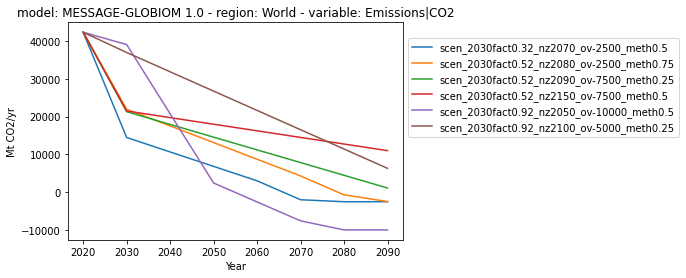

In [43]:
reconstructed.filter(year=[2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]).plot()
plt.legend(bbox_to_anchor=(1.0, .95))

<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

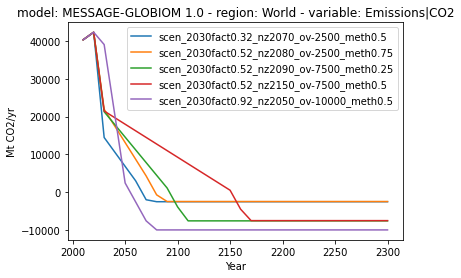

In [44]:
reconstructed.filter(scenario=predicted_labelled.index[:5]).plot()

<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

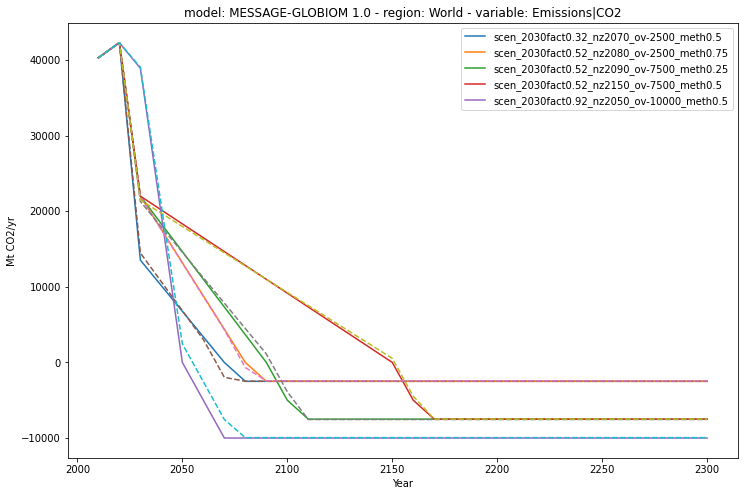

In [45]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
orig.filter(scenario=predicted_labelled.index[:5]).plot(ax=ax)
reconstructed.filter(scenario=predicted_labelled.index[:5]).plot(ax=ax, linestyle="--")

<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

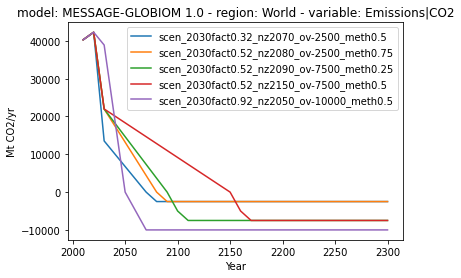

In [46]:
orig.filter(scenario=predicted_labelled.index[:5]).plot()

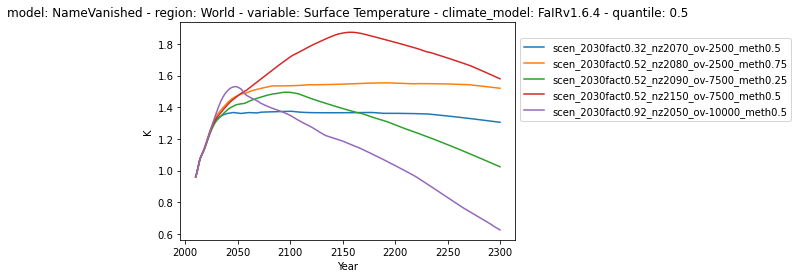

In [47]:
temps_py.filter(scenario=predicted_labelled.index[:5], quantile=0.5).plot()
plt.legend(bbox_to_anchor=(1.0, .95))

In [48]:
pca_test

,PCA1,PCA2,PCA3,PCA4,PCA5,quantile
scenario,,,,,,
scen_2030fact0.52_nz2080_ov-2500_meth0.75,-6.312956,-1.630926,0.083025,-0.329189,0.099470,0.10
scen_2030fact0.52_nz2150_ov-7500_meth0.5,2.762245,0.012313,-1.098490,0.276681,-0.074697,0.50
scen_2030fact0.92_nz2050_ov-10000_meth0.5,-8.074451,1.896011,-0.205361,0.210488,0.172768,0.50
scen_2030fact0.52_nz2090_ov-7500_meth0.25,-3.155468,1.173413,-0.460684,-0.043596,-0.257761,0.66
scen_2030fact0.32_nz2070_ov-2500_meth0.5,-3.173959,-0.859505,0.167578,-0.010793,-0.135991,0.50
...,...,...,...,...,...,...
scen_2030fact0.92_nz2200_ov-7500_meth0.75,18.021742,-1.566223,-1.137211,0.601926,0.473130,0.50
scen_2030fact0.32_nz2060_ov-5000_meth0.25,-3.659546,0.484621,0.251617,0.623918,-0.145677,0.90
scen_2030fact0.52_nz2090_ov-10000_meth0.25,-10.559181,0.048582,-0.904312,-0.274340,0.021728,0.10


# Attempt to map across different quantiles

In [49]:
dif_quant_test = pca_test.copy()
dif_quant_test["quantile"] = 0.5

In [50]:
pca_res_test

,factor2030,nzreduced,overshootreduced,methane
scenario,,,,
scen_2030fact0.52_nz2080_ov-2500_meth0.75,0.52,0.8,-0.25,0.75
scen_2030fact0.52_nz2150_ov-7500_meth0.5,0.52,1.5,-0.75,0.50
scen_2030fact0.92_nz2050_ov-10000_meth0.5,0.92,0.5,-1.00,0.50
scen_2030fact0.52_nz2090_ov-7500_meth0.25,0.52,0.9,-0.75,0.25
scen_2030fact0.32_nz2070_ov-2500_meth0.5,0.32,0.7,-0.25,0.50
...,...,...,...,...
scen_2030fact0.92_nz2200_ov-7500_meth0.75,0.92,2.0,-0.75,0.75
scen_2030fact0.32_nz2060_ov-5000_meth0.25,0.32,0.6,-0.50,0.25
scen_2030fact0.52_nz2090_ov-10000_meth0.25,0.52,0.9,-1.00,0.25


In [51]:
wrong_quant_pred = poly_model.predict(poly.fit_transform(dif_quant_test))

[array([[1.        , 0.14366091],
        [0.14366091, 1.        ]]),
 array([[1.        , 0.25354242],
        [0.25354242, 1.        ]]),
 array([[1.        , 0.16517296],
        [0.16517296, 1.        ]]),
 array([[ 1.        , -0.00931006],
        [-0.00931006,  1.        ]])]

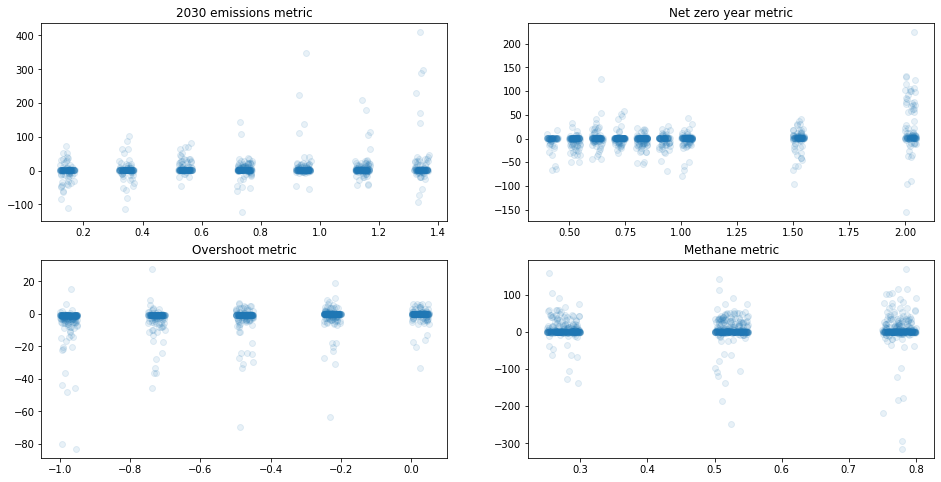

In [52]:
plt.figure(figsize=(16, 8))
corcoefsq5 = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(pca_res_test.iloc[:, i]+0.05*np.random.rand(len(pca_res_test)), wrong_quant_pred [:, i], alpha=0.1)
    plt.title(titles[i])
    corcoefsq5.append(np.corrcoef(pca_res_test.iloc[:, i], wrong_quant_pred [:, i]))
corcoefsq5

In [53]:
maxes = pca_res_test.max()
mins = pca_res_test.min()

In [54]:
def calc_wrong_fraction(npa, mins, maxes):
    # Encode link between column index and max/min reasonable values
    limits = {0: [0, 2], 1: [0.3, 3], 2: [-2, 0], 3: [0, 1]}
    wrong_fraction = pd.Series(index=range(npa.shape[1]), data = np.nan)
    for i in range(npa.shape[1]):
        wrong_fraction[i] = sum(
            (npa[:, i] > maxes[i]) | (npa[:, i] < mins[i])
        ) / len(npa)
    all_wrong_fraction = sum(
        (npa[:, 0] > limits[0][1]) | (npa[:, 0] < limits[0][0]) |
        (npa[:, 1] > limits[1][1]) | (npa[:, 1] < limits[1][0]) |
        (npa[:, 2] > limits[2][1]) | (npa[:, 2] < limits[2][0]) |
        (npa[:, 3] > limits[3][1]) | (npa[:, 3] < limits[3][0]) 
    ) / len(npa)
    return (all_wrong_fraction, wrong_fraction)

In [55]:
(all_wrong_fraction, wrong_fraction) = calc_wrong_fraction(wrong_quant_pred, mins, maxes)
print(all_wrong_fraction)
print(wrong_fraction)

0.7511111111111111
0    0.570000
1    0.647778
2    0.504444
3    0.794444
dtype: float64


In [56]:
(all_wrong_fraction, wrong_fraction) = calc_wrong_fraction(predicted, mins, maxes)
print(all_wrong_fraction)
print(wrong_fraction)

0.09666666666666666
0    0.102222
1    0.095556
2    0.198889
3    0.275556
dtype: float64


## Attempt via resolution into PCA of the corresponding quantile
Unfortunately the accuracy of the single-quantile decomposition is poor

In [57]:
temp_train = {}
temp_test = {}
temp_res_train = {}
temp_res_test = {}
for quantile in quantiles + ["all"]:
    if quantile != "all":
        temp_quant = decode_scen(temps.loc[temps["quantile"]==quantile,:].copy())
    else:
        temp_quant = decode_scen(temps)
    temp_train[quantile], temp_test[quantile], temp_res_train[quantile], temp_res_test[quantile] = train_test_split(
        temp_quant.loc[:, temp_quant.columns[6:-6]], 
        temp_quant.loc[:, functional_cols], test_size = 0.2, random_state = 4
    )
    

In [58]:
temp_train["all"]

,quantile,2010,2011,2012,2013,2014,2015,2016,2017,2018,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
68,0.10,0.932460,0.949167,0.965550,0.982788,0.998173,1.008862,1.019068,1.030615,1.043493,...,0.751899,0.750674,0.749448,0.748222,0.746995,0.745768,0.744541,0.743314,0.742086,0.740858
4312,0.90,0.996854,1.026663,1.060538,1.095789,1.129795,1.152418,1.173419,1.195069,1.217937,...,1.955835,1.953758,1.951673,1.949580,1.947479,1.945370,1.943253,1.941128,1.938995,1.936855
1432,0.33,0.949770,0.972187,0.993980,1.016519,1.037231,1.051114,1.064865,1.078919,1.093754,...,2.253393,2.252926,2.252453,2.251972,2.251485,2.250991,2.250491,2.249983,2.249469,2.248949
3983,0.90,0.996720,1.026592,1.060700,1.096540,1.131443,1.155099,1.177298,1.200421,1.224765,...,2.203888,2.203187,2.202474,2.201747,2.201008,2.200256,2.199491,2.198714,2.197924,2.197121
1310,0.33,0.949639,0.972135,0.994097,1.016984,1.038260,1.052955,1.067703,1.082837,1.098758,...,1.226404,1.226050,1.225693,1.225334,1.224971,1.224606,1.224237,1.223866,1.223491,1.223114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,0.90,0.996720,1.026592,1.060700,1.096540,1.131443,1.155099,1.177298,1.200421,1.224765,...,1.038604,1.035971,1.033335,1.030695,1.028050,1.025403,1.022751,1.020096,1.017438,1.014776
709,0.10,0.932539,0.949206,0.965461,0.982434,0.997389,1.007015,1.016305,1.026918,1.038919,...,1.337266,1.337038,1.336808,1.336574,1.336337,1.336097,1.335855,1.335609,1.335361,1.335110
2487,0.50,0.960186,0.982139,1.010964,1.041063,1.068669,1.086271,1.100091,1.114299,1.128455,...,1.775762,1.775994,1.776225,1.776452,1.776677,1.776900,1.777120,1.777337,1.777553,1.777765
174,0.10,0.932584,0.949229,0.965410,0.982231,0.996941,1.005958,1.014679,1.024605,1.035805,...,0.500101,0.498074,0.496049,0.494027,0.492006,0.489987,0.487971,0.485956,0.483944,0.481934


In [59]:
quant_to_inv = 0.66
poly_2 = PolynomialFeatures(degree=2)
temp_to_train = decomposers5[quant_to_inv].transform(temp_train[quant_to_inv].iloc[:, 1:])
temp_to_train = np.c_[temp_to_train, temp_train[quant_to_inv].loc[:, "quantile"].values]

temp_to_test = decomposers5[quant_to_inv].transform(temp_test[quant_to_inv].iloc[:, 1:])
temp_to_test = np.c_[temp_to_test, temp_test[quant_to_inv].loc[:, "quantile"].values]
poly_model = regression.fit(
    poly_2.fit_transform(temp_to_train), temp_res_train[quant_to_inv]
)
score = poly_model.score(
    poly_2.fit_transform(temp_to_test), temp_res_test[quant_to_inv]
)
score

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8119752091074354

In [60]:
quant_to_inv = 0.5
temp_to_train = decomposers5[quant_to_inv].transform(temp_train[quant_to_inv].iloc[:, 1:])
temp_to_train = np.c_[temp_to_train, temp_train[quant_to_inv].loc[:, "quantile"].values]

temp_to_test = decomposers5[quant_to_inv].transform(temp_test[quant_to_inv].iloc[:, 1:])
temp_to_test = np.c_[temp_to_test, temp_test[quant_to_inv].loc[:, "quantile"].values]
poly_model = regression.fit(
    poly_2.fit_transform(temp_to_train), temp_res_train[quant_to_inv]
)
score = poly_model.score(
    poly_2.fit_transform(temp_to_test), temp_res_test[quant_to_inv]
)
score

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7703933967818706

In [61]:
true_quant = 0.1
false_quant = quant_to_inv
assert true_quant != false_quant
wrong_quant_pcas = decomposers5[false_quant].transform(temp_test[true_quant].iloc[:, 1:])
wrong_quant_pcas = np.c_[wrong_quant_pcas, false_quant * np.ones((len(wrong_quant_pcas), 1))]
wrong_quant_results = poly_model.predict(poly_2.fit_transform(wrong_quant_pcas))

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Text(0, 0.5, 'Temperature (C)')

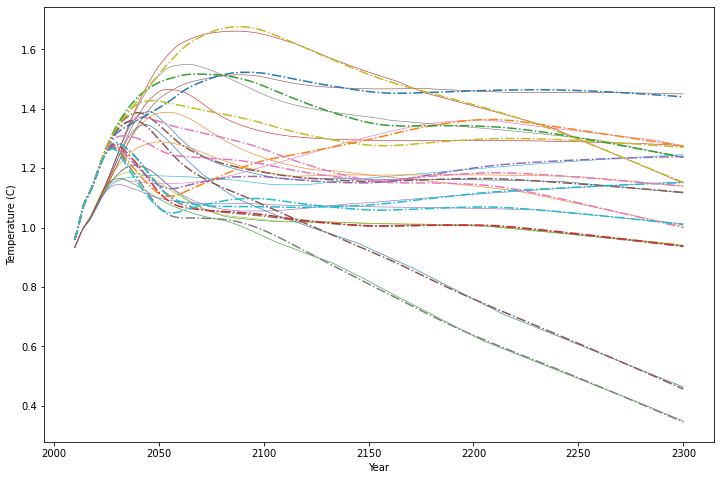

In [62]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
plt.plot(
    [int(x) for x in temp_test[true_quant].iloc[:15, 1:].columns], 
    temp_test[0.1].iloc[:15, 1:].T,
    linewidth=0.6
)
plt.plot(
    [int(x) for x in temp_test[true_quant].iloc[:15, 1:].columns],
    decomposers5[0.5].inverse_transform(
        decomposers5[0.5].transform(temp_test[0.1].iloc[:15, 1:])
    ).T,
    linestyle="-.",
)
plt.xlabel("Year")
plt.ylabel("Temperature (C)")

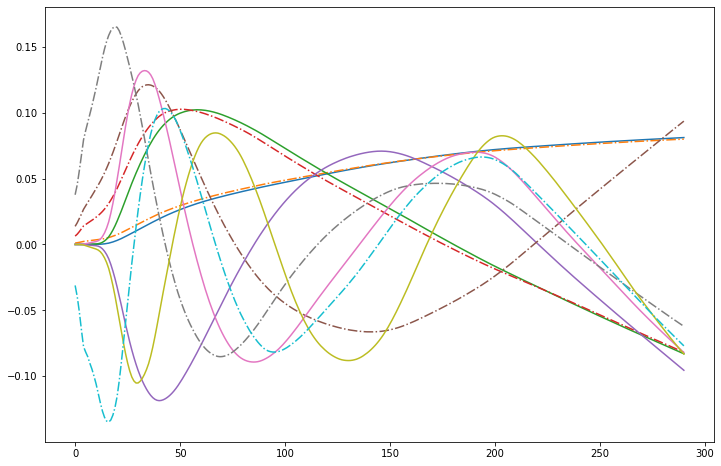

In [63]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
for i in range(5):
    plt.plot(
        decomposers5[0.1].components_[i]
    )
    plt.plot(
        decomposers5["all"].components_[i],
        linestyle="-.",
    )

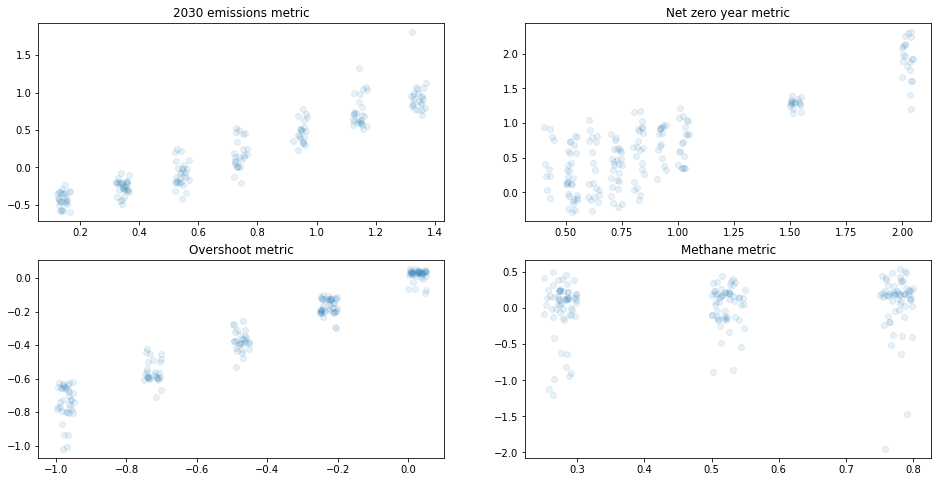

In [64]:
plt.figure(figsize=(16, 8))
corcoefsq5 = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(
        temp_res_test[quant_to_inv].iloc[:, i]+0.05*np.random.rand(len(wrong_quant_results)), 
        wrong_quant_results[:, i], alpha=0.1
    )
    plt.title(titles[i])
    #corcoefsq5.append(np.corrcoef(temp_res_test.iloc[:, i], wrong_quant_results[:, i]))
#corcoefsq5

In [65]:
(all_wrong_fraction, wrong_fraction) = calc_wrong_fraction(wrong_quant_results, mins, maxes)
print(all_wrong_fraction)
print(wrong_fraction)

0.8777777777777778
0    0.522222
1    0.411111
2    0.211111
3    0.816667
dtype: float64


In [73]:
# We can apply this to all other real quantiles too. 
false_quant = quant_to_inv
all_wrong = temps.loc[temps["quantile"]!=false_quant,:].copy()
assert true_quant != false_quant
wrong_quant_pcas = decomposers5[false_quant].transform(all_wrong.iloc[:, 7:-6])
wrong_quant_pcas = np.c_[wrong_quant_pcas, false_quant * np.ones((len(wrong_quant_pcas), 1))]
wrong_quant_results = poly_model.predict(poly_2.fit_transform(wrong_quant_pcas))

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [75]:
wrong_quant_results

array([[-0.74184752,  0.24727497, -0.57991767,  0.51646564],
       [-0.5767233 ,  0.12842382, -0.60119641,  0.5002272 ],
       [-0.46370644,  0.05965752, -0.62373022,  0.46589352],
       ...,
       [ 1.45051463,  1.85810943,  0.61730493,  1.22097917],
       [ 1.57939879,  1.76243443,  0.66127872,  1.14810799],
       [ 1.74268406,  1.54071909,  0.71382425,  0.96938313]])

In [76]:
(all_wrong_fraction, wrong_fraction) = calc_wrong_fraction(wrong_quant_results, mins, maxes)
print(all_wrong_fraction)
print(wrong_fraction)

0.6236111111111111
0    0.395556
1    0.336667
2    0.255833
3    0.601944
dtype: float64


# Reverse-engineer tier 1 temperature-defined pathways 

In [80]:
# Import data
tier1 = pd.read_csv("../output/chosen_files/v8/fair_temperatures/summary.csv")
tier1

,scenario,quantile,2010,2011,2012,2013,2014,2015,2016,2017,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,CurPol,0.10,0.864080,0.886840,0.910320,0.935020,0.957900,0.975400,0.989160,1.003100,...,5.078900,5.091480,5.103680,5.115160,5.126360,5.137560,5.148660,5.159860,5.170960,5.182580
1,CurPol,0.20,0.911500,0.935140,0.959240,0.984540,1.009340,1.028660,1.043560,1.060400,...,5.490980,5.507020,5.521540,5.534320,5.546700,5.559900,5.572660,5.585460,5.598160,5.611280
2,CurPol,0.30,0.947980,0.973360,0.999200,1.026100,1.050960,1.069120,1.085380,1.104300,...,5.808560,5.822740,5.837960,5.852780,5.867180,5.881140,5.894440,5.908640,5.921300,5.934220
3,CurPol,0.33,0.958676,0.983588,1.008264,1.034888,1.061088,1.081288,1.098488,1.115788,...,5.888540,5.903524,5.918720,5.933940,5.948976,5.964016,5.978968,5.993556,6.007188,6.021444
4,CurPol,0.40,0.980280,1.005440,1.031340,1.060560,1.086500,1.107500,1.124500,1.145080,...,6.106380,6.120880,6.136880,6.152720,6.167160,6.180760,6.194280,6.208980,6.223500,6.238680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,ModAct_OS_1.5C,0.60,1.044300,1.068260,1.095800,1.124820,1.153960,1.175700,1.194360,1.212800,...,1.621000,1.621000,1.621000,1.621000,1.621000,1.621000,1.621000,1.621000,1.621000,1.621000
238,ModAct_OS_1.5C,0.66,1.062076,1.087900,1.114652,1.143800,1.172776,1.196476,1.217128,1.237528,...,1.700828,1.700828,1.700828,1.700828,1.700828,1.700828,1.700828,1.700828,1.700828,1.700828
239,ModAct_OS_1.5C,0.70,1.074140,1.100500,1.129680,1.159420,1.189020,1.212400,1.232820,1.253360,...,1.775320,1.775320,1.775320,1.775320,1.775320,1.775320,1.775320,1.775320,1.775320,1.775320
240,ModAct_OS_1.5C,0.80,1.105540,1.132660,1.162380,1.195380,1.227020,1.252380,1.275600,1.298080,...,1.947240,1.947240,1.947240,1.947240,1.947240,1.947240,1.947240,1.947240,1.947240,1.947240


In [85]:
tier1.columns

Index(['scenario', 'quantile', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017',
       ...
       '2291', '2292', '2293', '2294', '2295', '2296', '2297', '2298', '2299',
       '2300'],
      dtype='object', length=293)

In [88]:
tier1pcas = decomposers5[0.5].transform(tier1.loc[tier1["quantile"]==0.5, [str(x) for x in np.arange(2010, 2301)]])
tier1pcas = np.c_[tier1pcas, 0.5 * np.ones((len(tier1pcas), 1))]
tier1revems = poly_model.predict(poly_2.fit_transform(tier1pcas))

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [90]:
calc_wrong_fraction(tier1revems, mins, maxes)

(0.8181818181818182,
 0    0.772727
 1    0.863636
 2    0.454545
 3    0.818182
 dtype: float64)

In [91]:
tier1revems

array([[ 1.67090312e+00,  5.06173550e+00,  2.86611361e+00,
        -1.33025078e+00],
       [ 1.80486779e+00, -1.00631633e+00, -2.55292980e-01,
        -1.00628212e+00],
       [ 1.15298683e+00,  4.04892947e-01, -5.24610552e-01,
         3.30497106e-01],
       [ 1.66887933e+00, -1.34087429e+00, -2.94045893e-01,
        -1.22006055e+00],
       [ 1.35895589e+00, -3.14435234e-01, -3.01164712e-01,
        -2.75433799e-01],
       [ 1.93529171e+00,  2.10507801e+00,  1.72002352e+00,
        -8.99427464e-01],
       [ 1.61918162e+00, -1.35312582e-01, -1.47260088e+00,
        -4.41562793e-01],
       [ 1.71182954e+00, -2.61344439e-01, -8.56661863e-01,
        -5.32370478e-01],
       [ 1.20012997e+00,  5.16820012e-02, -9.28530872e-02,
         1.17592720e-01],
       [ 1.06070296e+00,  3.33579909e-01, -2.32054945e-02,
         4.16770741e-01],
       [ 1.87227044e+00, -1.38985955e+00, -2.62262633e-01,
        -1.41524785e+00],
       [ 1.58210718e+00, -5.64868833e-01, -3.65950617e-01,
      